### Multi-Step Prediction for Lorenz time series

under supervision of prof. Gromov V.A.: https://www.hse.ru/org/persons/224066548#sci  
related article: https://www.researchgate.net/publication/347239842_Prediction_After_a_Horizon_of_Predictability_Non-Predictable_Points_and_Partial_Multi-Step_Prediction_for_Chaotic_Time_Series

In [1]:
import os
import json
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt('lorenz.txt', dtype=np.float32)
x0 = 3000
x1 = 13000
x2 = 14000
train_data = data[x0:x1]
test_data = data[x1:x2]

### 1. Training set construction.

<img src="training_set_construction.png" width="1600">

In [3]:
from itertools import product
patterns=np.array(list(product(np.arange(1, 11, 1),repeat=4)),dtype=np.uint8)
#np.save('patterns_all.npy', patterns)
patterns

array([[ 1,  1,  1,  1],
       [ 1,  1,  1,  2],
       [ 1,  1,  1,  3],
       ...,
       [10, 10, 10,  8],
       [10, 10, 10,  9],
       [10, 10, 10, 10]], dtype=uint8)

In [4]:
def training_set_constr(patterns, train_data):
    
    q = np.sum(patterns[:,:0],axis=1).reshape((patterns.shape[0],1))
    a = np.sum(patterns[:,:1],axis=1).reshape((patterns.shape[0],1))
    b = np.sum(patterns[:,:2],axis=1).reshape((patterns.shape[0],1))
    c = np.sum(patterns[:,:3],axis=1).reshape((patterns.shape[0],1))
    d = np.sum(patterns[:,:4],axis=1).reshape((patterns.shape[0],1))
    
    train_set = []
    for i in range(len(train_data) - np.max(d)):
        train_series = np.hstack((train_data[q+i], 
                                  train_data[a+i], 
                                  train_data[b+i], 
                                  train_data[c+i], 
                                  train_data[d+i]))
        train_set.append(train_series)
    
    train_set = np.array(train_set)
    train_set = np.stack(train_set, 1)
    
    return train_set

In [5]:
%%time
train_set = training_set_constr(patterns, train_data)
#np.save('train_set.npy', train_set)
print('training set shape: ',train_set.shape)
train_set[:2]

training set shape:  (10000, 9960, 5)
Wall time: 3.53 s


array([[[0.08588473, 0.25382462, 0.449447  , 0.51840115, 0.5491049 ],
        [0.25382462, 0.449447  , 0.51840115, 0.5491049 , 0.59208626],
        [0.449447  , 0.51840115, 0.5491049 , 0.59208626, 0.68580973],
        ...,
        [0.41697934, 0.265742  , 0.0476678 , 0.21193303, 0.47660547],
        [0.265742  , 0.0476678 , 0.21193303, 0.47660547, 0.57572174],
        [0.0476678 , 0.21193303, 0.47660547, 0.57572174, 0.6350129 ]],

       [[0.08588473, 0.25382462, 0.449447  , 0.51840115, 0.59208626],
        [0.25382462, 0.449447  , 0.51840115, 0.5491049 , 0.68580973],
        [0.449447  , 0.51840115, 0.5491049 , 0.59208626, 0.85483915],
        ...,
        [0.41697934, 0.265742  , 0.0476678 , 0.21193303, 0.57572174],
        [0.265742  , 0.0476678 , 0.21193303, 0.47660547, 0.6350129 ],
        [0.0476678 , 0.21193303, 0.47660547, 0.57572174, 0.721782  ]]],
      dtype=float32)

### 2. Predictive clustering pipeline

<img src="total_pipeline.png" width="1200">

1. Truncate 𝑧-vectors in the training set:

In [6]:
train_set = np.load('train_set.npy', mmap_mode='r+')
train_set_trunc = train_set[:,:,:-1]
print(train_set.shape, train_set_trunc.shape)

(10000, 9960, 5) (10000, 9960, 4)


2. Calculate Euclidean distances between the vector of last observations and vectors of truncated training set, correspondingly to each pattern:

#### Matrix of last observation construction (pull method)

<img src="last_observations.png" width="1500">

In [7]:
# Matrix of last observation
from numba import jit, njit, prange
@njit(parallel=True)
def last_vecs(patterns, train_data, K):
    last_obs = np.zeros((patterns.shape[0],4), dtype=np.float32)
    for i in prange(patterns.shape[0]):
        c_vec = (train_data.shape[0] - np.cumsum(patterns[i][::-1])).astype(np.int64)
        y1 = train_data[c_vec[0]]
        y2 = train_data[c_vec[1]]
        y3 = train_data[c_vec[2]]
        y4 = train_data[c_vec[3]]
        last_obs[i] = np.array([y4,y3,y2,y1],dtype=np.float32)
        if np.any(last_obs[i] == K[0]):
            last_obs[i] = 2*np.ones((4,), dtype=np.float32)
    return last_obs

In [8]:
# Calculation of Euclidean distances 
@jit(nopython=True, fastmath=True)
def euclidean(u, v):
    n = len(u)
    dist = 0
    for i in prange(n):
        dist += abs(u[i] - v[i]) ** 2 
    return dist ** (1 / 2)

@njit(parallel=True)
def vec_distance(train_set_trunc,last_obs,eps):
    n, m = train_set_trunc.shape[0], train_set_trunc.shape[1]
    dist=np.zeros((n, m), dtype=np.float32)
    for i in prange(n):
        for j in prange(m):
            dist[i,j] = euclidean(last_obs[i], train_set_trunc[i,j])
    return dist

3. Get all distances which are less than predefined 𝜀, where 𝜀 is a small threshold, for example 𝜀 = 0.02  
and  
4. According to the indices of these distances get corresponding truncated 𝑦-values:  

In [9]:
@njit(parallel=True)
def forecast_set(dist, train_set, eps):
    idx = (dist < eps).nonzero()
    train_idx = np.vstack((idx[0], idx[1])).T
    k = train_idx.shape[0]
    forecast_values = np.zeros((k, 1), dtype=np.float32)
    weight_values = np.zeros((k, 1), dtype=np.float32)
    for i in prange(k):
        forecast_values[i] = train_set[train_idx[i,0], train_idx[i,1],4]
        weight_values[i] = 1 - dist[train_idx[i,0], train_idx[i,1]] / eps
    return forecast_values, weight_values

5. Cluster these truncated 𝑦-values,  get 𝑦_𝑚𝑒𝑎𝑛 and update the last 𝑦-value:

In [10]:
from dbscan1d.core import DBSCAN1D
def y_mean(forecast_values, weight_values, eps_dbscan, K):    
    
    # get labels from DBSCAN applied to y-values where distances are < ε_of_pipeline
    dbscan = DBSCAN1D(eps=eps_dbscan, min_samples=3).fit(forecast_values)
    labels = dbscan.labels_
    
    # get clusters without noise
    clusters = np.stack(np.unique(labels, return_counts = True),1)
    clusters_wn = clusters[clusters[:,0]>-1]
    
    # decision on the non-predictability of the point:
    if clusters_wn.shape[0] == 0: # if size of the cluster is zero
        y_mean_1 = y_mean_2 = K[0] # assign this point as non-predictable 
        mean_weight_1 = mean_weight_2 = 1e-5 # and assign a very low weight to it
    
    elif clusters_wn[:,1].size == 1: # get 1st and 2nd y-av. value and ω-av. value
        y_mean_1 = y_mean_2 = np.mean(forecast_values[np.where(labels == 0)])
        mean_weight_1 = mean_weight_2 = np.mean(weight_values[np.where(labels == 0)])
    
    else:
        sorted_labels = np.argsort(clusters_wn[:,1], axis=0) # sort clusters by their cardinalities
        first_cl = clusters_wn[:,0][sorted_labels[-1]] # get 1st 
        second_cl = clusters_wn[:,0][sorted_labels[-2]] # and 2nd largest clusters
        
        # if 1st largest cluster > 10% of all clusters without noise:
        if clusters_wn[first_cl,1] > 0.10*np.sum(clusters_wn[:,1]):
            
            # get 1st and 2nd y-av. values as the mean y-values of respective largest cluster
            y_mean_1 = np.mean(forecast_values[np.where(labels == first_cl)])
            y_mean_2 = np.mean(forecast_values[np.where(labels == second_cl)])
            
            # get 1st and 2nd ω-av. values as the mean ω-values of respective largest cluster
            mean_weight_1 = np.mean(weight_values[np.where(labels == first_cl)])
            mean_weight_2 = np.mean(weight_values[np.where(labels == second_cl)])
        
        else: # decision on the non-predictability of the point:
            y_mean_1 = y_mean_2 = K[0] # assign this point as non-predictable 
            mean_weight_1 = mean_weight_2 = 1e-5 # and assign a very low weight to it
    
    # get 1st and 2nd y-av. values and ω-av. values respectively 
    return y_mean_1, y_mean_2, mean_weight_1, mean_weight_2

### 2. Predictive clustering pipeline:

<img src="fan_of_trajectories.png" width="800">

In [11]:
from tqdm import tqdm
def clustering_pipeline(train_data, train_set, train_set_trunc, patterns, eps, eps_dbscan, K, S_max, h):
    
    train_data_all = np.array([train_data]) # convert time series list to array
    weights_all = np.array([1], dtype=np.float32) # initial weight series
    
    # for each step in h:
    for i in tqdm(range(h)):
        trajectories = []
        weights = []
  
        # for each y-values and ω-values of trajectory in all trajectories in each step:
        for trajectory, weight in zip(train_data_all, weights_all):
            
            # calculate matrix of last observation
            last_obs = last_vecs(patterns, trajectory, K)
            
            # calculate distances between the matrix and the training set
            dist = vec_distance(train_set_trunc, last_obs, eps)
            
            # get a possible prediction values: y-values and ω-values where distances are < ε
            forecast_values, weight_values = forecast_set(dist, train_set, eps)
            
            # decision on the non-predictability of the point:
            if forecast_values.size == 0: # if there is no y-values:
                y_mean_1 = y_mean_2 = K[0] # assign it as a non-predictable point         
                mean_weight_1 = mean_weight_2 = 1e-5 # and assign a very low weight to it
                
            else: # get average y-values and ω-values of 1st and 2nd clusters respectively from y_mean function   
                y_mean_1, y_mean_2, mean_weight_1, mean_weight_2 = y_mean(forecast_values, weight_values, eps_dbscan, K)
            
            # binary tree:
            # accumulate these two pairs of values for related trajectory in each step:
            train_data_1 = np.hstack((trajectory, y_mean_1))
            train_data_2 = np.hstack((trajectory, y_mean_2))
            train_data_12 = np.vstack((train_data_1, train_data_2))
            trajectories.append(train_data_12)
            
            weights_1 = np.hstack((weight, mean_weight_1))
            weights_2 = np.hstack((weight, mean_weight_2))
            weights_12 = np.vstack((weights_1, weights_2))
            weights.append(weights_12)
   
        # stack all accumulated trajectories and their weights:
        train_data_all = np.vstack(trajectories)
        weights_all = np.vstack(weights)
        
        # truncation and weights of trajectories update:
        if weights_all.shape[0] > S_max: # if number of all trajectories becomes > S_max
            traj_weights = np.prod(weights_all, 1)
            threshold = np.sort(traj_weights)[::-1][S_max-1]
            top_traj_weights = np.where(traj_weights >= threshold)[0]
            train_data_all = train_data_all[top_traj_weights] # leave only S_max trajectories, the heaviest by weights 
            weights_all = weights_all[top_traj_weights]
    
    # get a matrix with S_max rows and h y-values
    return train_data_all[:,-h:]

In [13]:
eps=0.02
eps_dbscan=0.001
S_max=128
h=10
K = np.array([0.7777], dtype=np.float32)
patterns = np.load('patterns_all.npy')
trajs = clustering_pipeline(train_data, train_set, train_set_trunc, patterns, eps, eps_dbscan, K, S_max, h)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.50s/it]


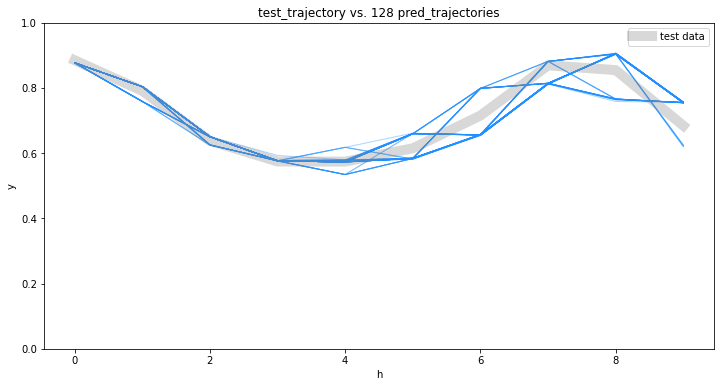

In [57]:
plt.figure(figsize=(12,6))
for i in range(trajs.shape[0]):
    plt.plot(trajs[i,:], c='dodgerblue', linewidth=1, alpha=0.2)
plt.plot(test_data[:h], label='test data', c='grey', linewidth=10, alpha=0.3); 
plt.title('test_trajectory vs. {} pred_trajectories'.format(S_max))
plt.xlabel('h')
plt.ylabel('y')
plt.ylim(0, 1)
plt.legend()
plt.show();

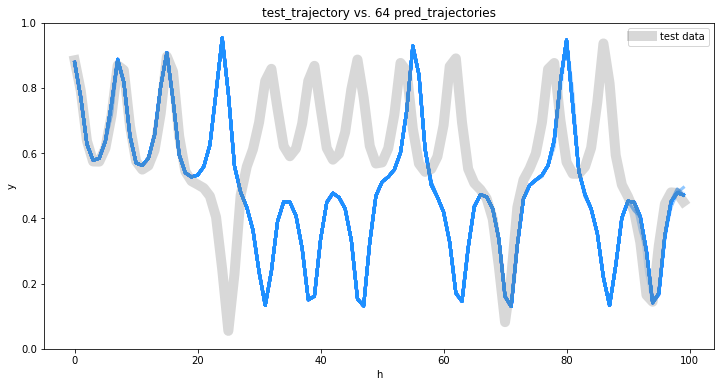

In [337]:
plt.figure(figsize=(12,6))
for i in range(trajs.shape[0]):
    plt.plot(trajs[i,:], c='dodgerblue', linewidth=3, alpha=0.2)
plt.plot(test_data[:h], label='test data', c='grey', linewidth=10, alpha=0.3); 
plt.title('test_trajectory vs. {} pred_trajectories'.format(S_max))
plt.xlabel('h')
plt.ylabel('y')
plt.ylim(0, 1)
plt.legend()
plt.show();

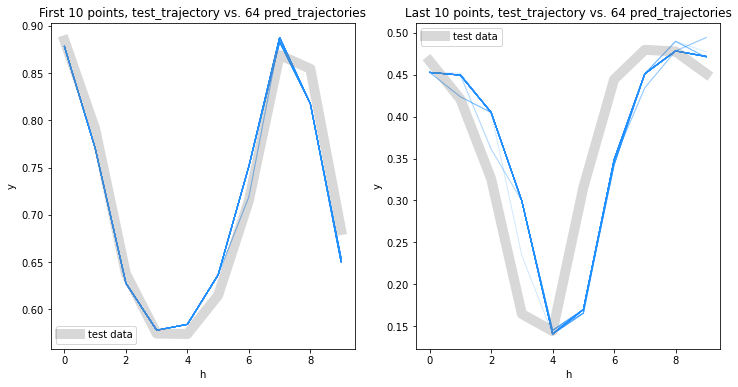

In [338]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for i in range(trajs.shape[0]):
    plt.plot(trajs[i,:10], c='dodgerblue', linewidth=1, alpha=0.2)
plt.plot(test_data[:10], label='test data', c='grey', linewidth=10, alpha=0.3); 
plt.title('First 10 points, test_trajectory vs. {} pred_trajectories'.format(S_max))
plt.xlabel('h')
plt.ylabel('y')
plt.legend()

plt.subplot(1,2,2)
for i in range(trajs.shape[0]):
    plt.plot(trajs[i,-10:], c='dodgerblue', linewidth=1, alpha=0.2)
plt.plot(test_data[h-10:h], label='test data', c='grey', linewidth=10, alpha=0.3); 
plt.title('Last 10 points, test_trajectory vs. {} pred_trajectories'.format(S_max))
plt.xlabel('h')
plt.ylabel('y')
plt.legend()
plt.show();

### 3. Predictions post-processing

<img src="get_metrics.png" width="1200">

In [12]:
def trajectories_set(train_data, test_data, train_set, train_set_trunc, patterns, eps, eps_dbscan, K, S_max, h):    
    pred_trajectories_set = []
    for i in tqdm(range(len(test_data))):
        if (i <= len(test_data) - h):
            # get forecast applying trajectory algorithm and respective test data, 
            # with training data and training set shifting the length of test data by 1 step
            pred_trajectories = clustering_pipeline(np.append(train_data, test_data[:i]), train_set, train_set_trunc, patterns, eps, eps_dbscan, K, S_max, h)   
        pred_trajectories_set.append(pred_trajectories)
    
    test_trajectories_set = []
    for i in range(len(test_data)):
        if (i <= len(test_data) - h):
            # get test trajectories 
            # shifting the length of test data by 1 step
            test_trajectories = test_data[i: i + h].tolist()
        test_trajectories_set.append(test_trajectories)
        
    return pred_trajectories_set, test_trajectories_set

In [20]:
def cluster_ends_of_trajectories(pred_trajectories_set, test_trajectories_set, K):

    ends_of_trajectories_means =[]
    # for step in length of h:
    for i in range(len(pred_trajectories_set)):
        ends_of_trajectories_row_means =[]
        
        # for forecasted trajectories in each step:
        for j in range(pred_trajectories_set[i].shape[1]):
            ends_of_trajectories_set = pred_trajectories_set[i][:,j]
            # get labels from applying DBSCAN to the last points of trajectories
            dbscan = DBSCAN1D(eps=0.001, min_samples=2).fit(ends_of_trajectories_set.reshape(ends_of_trajectories_set.shape[0],1))
            labels = dbscan.labels_
        
            # get clusters without noise
            clusters_all = np.stack(np.unique(labels, return_counts = True),1)
            clusters_wn = clusters_all[clusters_all[:,0]>-1]
            
            # decision on the non-predictability of the point:
            if clusters_wn.shape[0] == 0: # if size of the cluster is zero
                ends_of_trajectories_mean = K[0] # assign this point as a non-predictable
            
            else: # sort clusters by their cardinalities
                sorted_labels = np.argsort(clusters_wn[:,1], axis=0)
                max_cl = clusters_wn[:,0][sorted_labels[-1]] # get the largest cluster
                
                # if largest cluster > 10% of all clusters without noise
                if clusters_wn[max_cl,1] > 0.10 * np.sum(clusters_wn[:,1]):
                    
                    # get y-av. value as the mean of y-values of this largest cluster
                    ends_of_trajectories_mean = np.mean(ends_of_trajectories_set[np.where(labels == max_cl)])
                
                else: # decision on the non-predictability of the point: 
                    ends_of_trajectories_mean = K[0]
            
            ends_of_trajectories_row_means.append(ends_of_trajectories_mean)             
        ends_of_trajectories_means.append(ends_of_trajectories_row_means)
        
    # get accumulated y-av. values for each step
    return ends_of_trajectories_means

### 4. Metrics

In [14]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
def get_metrics(ends_of_trajectories_means, test_trajectories_set, h, K):
    
    def get_cols(traj_points, i):
        return [traj_points[n][i] for n in range(len(traj_points))]
   
    predictions_set = [list(zip(get_cols(test_trajectories_set, i),
                                get_cols(ends_of_trajectories_means, i)))[:-h] for i in range(h)]
    rmse = []
    mape = []
    non_pred_points = []
    pred_points = []
    
    for i in range(len(predictions_set)):
        y_values = []
        non_pred_point = 0
        
        for y in predictions_set[i]:
            if K[0] in y:
                non_pred_point += 1
            else:
                y_values.append([y[0], y[1]])
        
        y_values = np.array(y_values)
        y_true = y_values[:,0]
        y_pred = y_values[:,1]
        
        non_pred_points.append(non_pred_point/len(predictions_set[i]))
        pred_points.append(1-(non_pred_point/len(predictions_set[i])))
        
        rmse_score = MSE(y_true, y_pred, squared=False)
        mape_score = MAPE(y_true, y_pred)
        rmse.append(rmse_score)
        mape.append(mape_score)
        
    return rmse, mape, non_pred_points, pred_points

### 5. Calculations

#### h=10

In [15]:
K = np.array([0.7777], dtype=np.float32)
patterns = np.load('patterns_all.npy')
x1 = 13000
x2 = 14000
eps = 0.02
eps_dbscan=0.001
h = 10
S_max = 32
test_data = data[x1:x2 + h]

In [ ]:
pred_trajectories_set, test_trajectories_set = trajectories_set(train_data, test_data, train_set, train_set_trunc, patterns, eps, eps_dbscan, K, S_max, h)

In [27]:
pred_trajectories_set = np.load('pred_trajectories_set.npy', allow_pickle=True).tolist()
with open('test_trajectories_set.txt') as f:
    test_trajectories_set = json.load(f)

In [28]:
ends_of_trajectories_means = cluster_ends_of_trajectories(pred_trajectories_set, test_trajectories_set, K)
rmse, mape, non_pred_points, pred_points = get_metrics(ends_of_trajectories_means, test_trajectories_set, h, K)

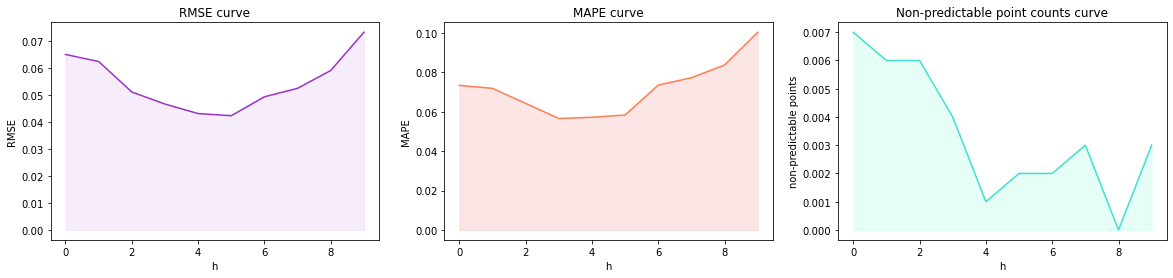

In [29]:
plt.figure(figsize = (20,4))
x = np.arange(10)
plt.subplot(1,3,1)
plt.title('RMSE curve')
plt.plot(x, rmse, color ='darkorchid')
plt.fill_between(x, rmse, color='mediumorchid', alpha=0.1)
plt.xlabel('h')
plt.ylabel('RMSE')
    
plt.subplot(1,3,2)
plt.title('MAPE curve')
plt.plot(x, mape, color ='coral')
plt.fill_between(x, mape, color='lightcoral', alpha=0.2)
plt.xlabel('h')
plt.ylabel('MAPE')

plt.subplot(1,3,3)
plt.title('Non-predictable point counts curve')
plt.plot(x, non_pred_points, color='turquoise')
plt.fill_between(x, non_pred_points, color='aquamarine', alpha=0.2)
#plt.axhline(y=1, color='turquoise', lw=0.5)
#plt.ylim([0.98, 1.02])
plt.xlabel('h')
plt.ylabel('non-predictable points');
plt.show()

In [30]:
from sklearn.metrics import auc
print('rmse_auc =', auc(x, rmse))
print('mape_auc =', auc(x, mape))
print('non_pred_points_auc =', auc(x, non_pred_points))
result = auc(x, rmse) * auc(x, mape) * auc(x, non_pred_points)
result

rmse_auc = 0.4768421428205864
mape_auc = 0.630050150938476
non_pred_points_auc = 0.029


0.00871259945768017

In [31]:
result = auc(x, mape) * auc(x, non_pred_points)
result

0.018271454377215807

#### h=100

In [16]:
pred_trajectories_set2 = np.load('pred_trajectories_set2.npy', allow_pickle=True).tolist()
test_trajectories_set2 = np.load('test_trajectories_set2.npy', allow_pickle=True).tolist()

In [17]:
x1 = 13000
x2 = 13200
h = 100
test_data = data[x1:x2 + h]
K = np.array([0.7777], dtype=np.float32)

In [21]:
ends_of_trajectories_means2 = cluster_ends_of_trajectories(pred_trajectories_set2, test_trajectories_set2, K)
rmse2, mape2, non_pred_points2, pred_points2 = get_metrics(ends_of_trajectories_means2, test_trajectories_set2, h, K)

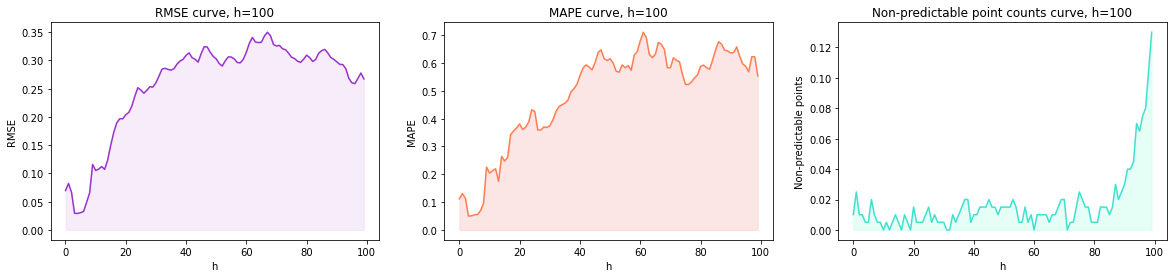

In [22]:
plt.figure(figsize = (20,4))
x = np.arange(100)
plt.subplot(1,3,1)
plt.title('RMSE curve, h=100')
plt.plot(x, rmse2, color ='darkorchid')
plt.fill_between(x, rmse2, color='mediumorchid', alpha=0.1)
plt.xlabel('h')
plt.ylabel('RMSE')
    
plt.subplot(1,3,2)
plt.title('MAPE curve, h=100')
plt.plot(x, mape2, color ='coral')
plt.fill_between(x, mape2, color='lightcoral', alpha=0.2)
plt.xlabel('h')
plt.ylabel('MAPE')

plt.subplot(1,3,3)
plt.title('Non-predictable point counts curve, h=100')
plt.plot(x, non_pred_points2, color='turquoise')
plt.fill_between(x, non_pred_points2, color='aquamarine', alpha=0.2)
plt.xlabel('h')
plt.ylabel('Non-predictable points');
plt.show()